Epoch 1; Elapsed time = 0s
1870/1875: G=1.316, Dr=0.531, Df=0.534
Epoch 2; Elapsed time = 51s
1870/1875: G=1.099, Dr=0.577, Df=0.572
Epoch 3; Elapsed time = 101s
1870/1875: G=1.108, Dr=0.574, Df=0.569
Epoch 4; Elapsed time = 151s
1870/1875: G=1.161, Dr=0.565, Df=0.557
Epoch 5; Elapsed time = 201s
1870/1875: G=1.227, Dr=0.545, Df=0.535
Epoch 6; Elapsed time = 252s
1870/1875: G=1.319, Dr=0.522, Df=0.509
Epoch 7; Elapsed time = 302s
1870/1875: G=1.429, Dr=0.498, Df=0.481
Epoch 8; Elapsed time = 352s
1870/1875: G=1.574, Dr=0.470, Df=0.452
Epoch 9; Elapsed time = 402s
1870/1875: G=1.677, Dr=0.450, Df=0.432
Epoch 10; Elapsed time = 453s
1870/1875: G=1.765, Dr=0.437, Df=0.419


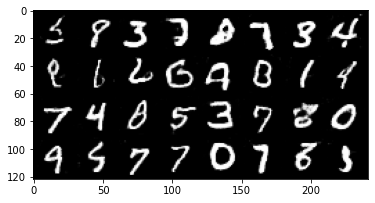

In [28]:
import os
import torch
from torch import nn
from torch import optim
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import save_image


class Generator(nn.Module):
    def __init__(self, latent_dim=100, batchnorm=True):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.batchnorm = batchnorm
        self._init_modules()

    def _init_modules(self):
        self.linear1 = nn.Linear(self.latent_dim, 256*7*7, bias=False)
        self.bn1d1 = nn.BatchNorm1d(256*7*7) if self.batchnorm else None
        self.leaky_relu = nn.LeakyReLU()

        # Convolutions
        self.conv1 = nn.Conv2d(
                in_channels=256,
                out_channels=128,
                kernel_size=5,
                stride=1,
                padding=2,
                bias=False)
        self.bn2d1 = nn.BatchNorm2d(128) if self.batchnorm else None

        self.conv2 = nn.ConvTranspose2d(
                in_channels=128,
                out_channels=64,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False)
        self.bn2d2 = nn.BatchNorm2d(64) if self.batchnorm else None

        self.conv3 = nn.ConvTranspose2d(
                in_channels=64,
                out_channels=1,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False)
        self.tanh = nn.Tanh()

    def forward(self, input_tensor):
        intermediate = self.linear1(input_tensor)
        intermediate = self.bn1d1(intermediate)
        intermediate = self.leaky_relu(intermediate)

        intermediate = intermediate.view((-1, 256, 7, 7))

        intermediate = self.conv1(intermediate)
        if self.batchnorm:
            intermediate = self.bn2d1(intermediate)
        intermediate = self.leaky_relu(intermediate)

        intermediate = self.conv2(intermediate)
        if self.batchnorm:
            intermediate = self.bn2d2(intermediate)
        intermediate = self.leaky_relu(intermediate)

        intermediate = self.conv3(intermediate)
        output_tensor = self.tanh(intermediate)
        return output_tensor


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self._init_modules()  # I know this is overly-organized. Fight me.

    def _init_modules(self):
        self.conv1 = nn.Conv2d(
                in_channels=1,
                out_channels=64,
                kernel_size=5,
                stride=2,
                padding=2,
                bias=True)
        self.leaky_relu = nn.LeakyReLU()
        self.dropout_2d = nn.Dropout2d(0.3)

        self.conv2 = nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=5,
                stride=2,
                padding=2,
                bias=True)

        self.linear1 = nn.Linear(128*7*7, 1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor):
        intermediate = self.conv1(input_tensor)
        intermediate = self.leaky_relu(intermediate)
        intermediate = self.dropout_2d(intermediate)

        intermediate = self.conv2(intermediate)
        intermediate = self.leaky_relu(intermediate)
        intermediate = self.dropout_2d(intermediate)

        intermediate = intermediate.view((-1, 128*7*7))
        intermediate = self.linear1(intermediate)
        output_tensor = self.sigmoid(intermediate)

        return output_tensor


class DCGAN():
    def __init__(self, latent_dim, noise_fn, dataloader,
                 batch_size=32, device='cpu', lr_d=1e-3, lr_g=2e-4):
        self.generator = Generator(latent_dim).to(device)
        self.discriminator = Discriminator().to(device)
        self.noise_fn = noise_fn
        self.dataloader = dataloader
        self.batch_size = batch_size
        self.device = device
        self.criterion = nn.BCELoss()
        self.optim_d = optim.Adam(self.discriminator.parameters(),
                                  lr=lr_d, betas=(0.5, 0.999))
        self.optim_g = optim.Adam(self.generator.parameters(),
                                  lr=lr_g, betas=(0.5, 0.999))
        self.target_ones = torch.ones((batch_size, 1), device=device)
        self.target_zeros = torch.zeros((batch_size, 1), device=device)

    def generate_samples(self, latent_vec=None, num=None):
        num = self.batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        with torch.no_grad():
            samples = self.generator(latent_vec)
        samples = samples.cpu()  # move images to cpu
        return samples

    def train_step_generator(self):
        self.generator.zero_grad()
        latent_vec = self.noise_fn(self.batch_size)
        generated = self.generator(latent_vec)
        classifications = self.discriminator(generated)
        loss = self.criterion(classifications, self.target_ones)
        loss.backward()
        self.optim_g.step()
        return loss.item()

    def train_step_discriminator(self, real_samples):
        self.discriminator.zero_grad()

        # real samples
        pred_real = self.discriminator(real_samples)
        loss_real = self.criterion(pred_real, self.target_ones)

        # generated samples
        latent_vec = self.noise_fn(self.batch_size)
        with torch.no_grad():
            fake_samples = self.generator(latent_vec)
        pred_fake = self.discriminator(fake_samples)
        loss_fake = self.criterion(pred_fake, self.target_zeros)

        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_d.step()
        return loss_real.item(), loss_fake.item()

    def train_epoch(self,  all_g_loss, all_dr_loss, all_df_loss, epoch, print_frequency=10, max_steps=0):
        loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
        for batch, (real_samples, _) in enumerate(self.dataloader):
            real_samples = real_samples.to(self.device)
            ldr_, ldf_ = self.train_step_discriminator(real_samples)
            loss_d_real_running += ldr_
            loss_d_fake_running += ldf_
            loss_g_running += self.train_step_generator()
            if print_frequency and (batch+1) % print_frequency == 0:
                print(f"{batch+1}/{len(self.dataloader)}:"
                      f" G={loss_g_running / (batch+1):.3f},"
                      f" Dr={loss_d_real_running / (batch+1):.3f},"
                      f" Df={loss_d_fake_running / (batch+1):.3f}",
                      end='\r',
                      flush=True)
                all_g_loss.append(loss_g_running / (batch+1))
                all_dr_loss.append(loss_d_real_running / (batch+1))
                all_df_loss.append(loss_d_fake_running / (batch+1))
                if not os.path.exists('MNIST_DCGAN_results/dcgan_1_results/{}'.format(epoch)):
                    os.makedirs('MNIST_DCGAN_results/dcgan_1_results/{}'.format(epoch))
                images = self.generate_samples(num=64)  # invert colours, for aesthetics
                ims = tv.utils.make_grid(images, normalize=True)
                save_image(ims, os.path.join('MNIST_DCGAN_results/dcgan_1_results/{}'.format(epoch), 'sample{}.png'.format(batch+1)), nrow=8)
            if max_steps and batch == max_steps:
                break
        if print_frequency:
            print()
        loss_g_running /= batch
        loss_d_real_running /= batch
        loss_d_fake_running /= batch
        return (loss_g_running, (loss_d_real_running, loss_d_fake_running))


#def main():
import matplotlib.pyplot as plt
from time import time
import os
batch_size = 32
epochs = 100
latent_dim = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = tv.transforms.Compose([
        tv.transforms.Grayscale(num_output_channels=1),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.5,), (0.5,))
        ])
dataset = ImageFolder(
        root="data/mnist_png/mnist_png/training",
        transform=transform
        )
dataloader = DataLoader(dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
        )
noise_fn = lambda x: torch.randn((x, latent_dim), device=device)
gan = DCGAN(latent_dim, noise_fn, dataloader, device=device, batch_size=batch_size)
start = time()
all_g=[]
all_dr=[]
all_df=[]
for i in range(10):
    print(f"Epoch {i+1}; Elapsed time = {int(time() - start)}s")
    gan.train_epoch(all_g, all_dr, all_df,i)
images = gan.generate_samples()  # invert colours, for aesthetics
ims = tv.utils.make_grid(images, normalize=True)
plt.imshow(ims.numpy().transpose((1,2,0)))
plt.show()

In [37]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

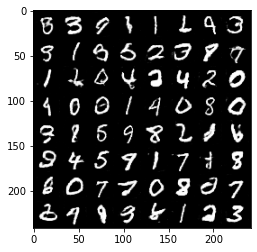

torch.Size([3, 242, 242])

In [4]:
images = gan.generate_samples(num=64)  
ims = tv.utils.make_grid(images, normalize=True)
# ims = ims.reshape(64, 3, 28, 28)
plt.imshow(ims.numpy().transpose((1,2,0)))
plt.show()
ims.shape
#save_image(ims, os.path.join('MNIST_DCGAN_results/dcgan_1_results/', 'sample1.png'), nrow=10)

In [35]:
import imageio
files=[]
sample_dir = './MNIST_DCGAN_results/dcgan_1_results/'

for d in range(3):
    for f in [50+50*i for i in range(37)]:
        files.append(os.path.join(sample_dir,str(d),'sample'+str(f)+'.png'))
images =[imageio.imread(i) for i in files]
#imageio.imread(os.path.join(sample_dir, str(d), f ))
imageio.mimsave('MNIST_DCGAN_results/dcgan_1_results/generation_animation.mp4', images, fps=5)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (242, 242) to (256, 256) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


<img src = './MNIST_DCGAN_results/dcgan_1_results/generation_animation.mp4'>

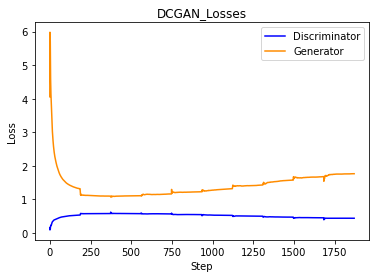

In [36]:
import matplotlib.pyplot as plt
plt.plot(all_dr, '-',color='blue')
plt.plot(all_g, '-',color='darkorange')

plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('DCGAN_Losses')
plt.savefig('MNIST_DCGAN_results/gan_loss.png')